In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as dd
import datetime
from datetime import date


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score, precision_recall_curve, classification_report

from sklearn.feature_selection import SelectFromModel, GenericUnivariateSelect, mutual_info_classif

In [2]:
from until import ColumnSelector, preprocess_data_train, preprocess_data_test, select_type_cols

In [3]:
TRAIN_DATA = 'data/data_train.csv'
TEST_DATA = 'data/data_train.csv'
FEATURES_DATA = 'data/features.csv'
RANDOM_STATE = 21

In [4]:
train_df = pd.read_csv(TRAIN_DATA)

In [5]:
train_df.head(2)

,Unnamed: 0,id,vas_id,buy_time,target
0,0,540968,8.0,1537131600,0.0
1,1,1454121,4.0,1531688400,0.0


Достанем данные из временной метки, и посмотрим распределение целевого признака в разрезе остальных признаков.

In [6]:
train_df = train_df.drop('Unnamed: 0', axis=1)

In [7]:
train_df['date'] = pd.to_datetime(train_df['buy_time'], unit='s') 
#train_df['date'] =  train_df['buy_time'].apply(lambda x: date.fromtimestamp(x))

In [8]:
train_df['buy_time'].dtypes

dtype('int64')

In [9]:
train_df['date'].dtypes

dtype('<M8[ns]')

In [10]:
train_df['vas_id'].value_counts()

1.0    310175
2.0    249505
5.0     94085
4.0     85756
6.0     57878
7.0     15432
8.0     13350
9.0      5472
Name: vas_id, dtype: int64

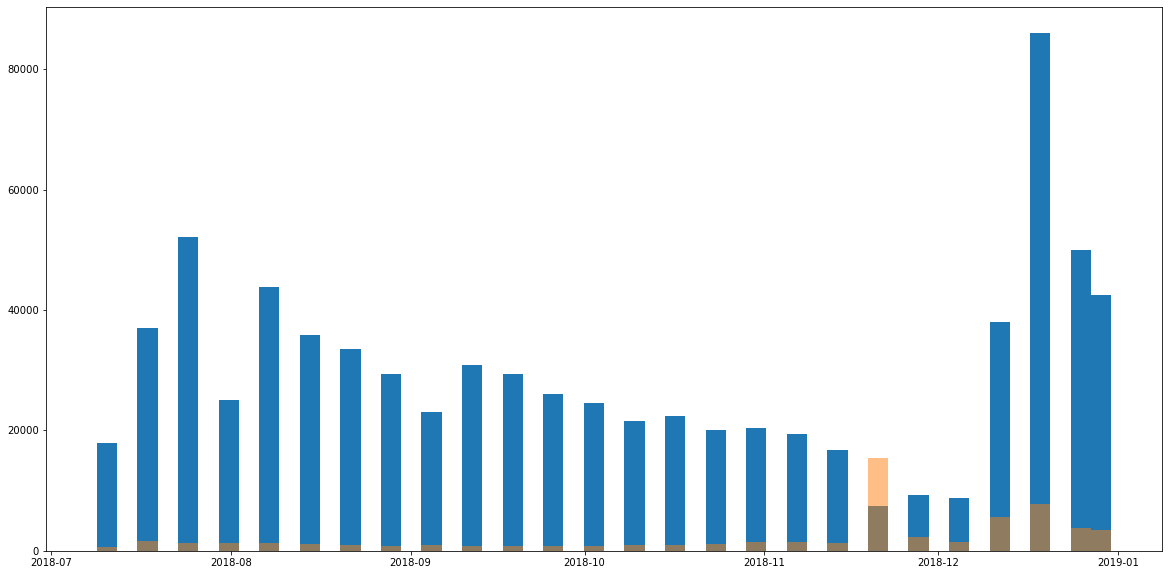

In [11]:
plt.figure(figsize=(20,10))
plt.hist(train_df.loc[(train_df['target']==0, 'date') ], bins=50, rwidth=5, stacked=False)
plt.hist(train_df.loc[(train_df['target']==1, 'date') ], bins=50, rwidth=5, stacked=False, alpha=0.5)
plt.show()

Видно, что из месяца в месяц к-во предложений которое делалось пользователям по услугам  уменьшалось.

In [12]:
train_df['monthday'] = train_df['date'].dt.day
train_df['month'] = train_df['date'].dt.month

In [13]:
train_df.head(2)

,id,vas_id,buy_time,target,date,monthday,month
0,540968,8.0,1537131600,0.0,2018-09-16 21:00:00,16,9
1,1454121,4.0,1531688400,0.0,2018-07-15 21:00:00,15,7


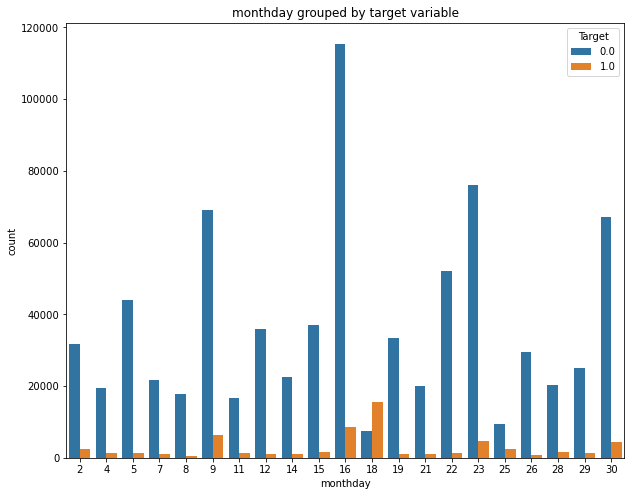

In [14]:
plt.figure(figsize=(10, 8))

sns.countplot(x="monthday", hue='target', data=train_df)
plt.title('monthday grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()


 В какой-то момент 18-11-2018 к-во пользователей, которые приобрели услуги оказлалось больше чем отказавшихся.

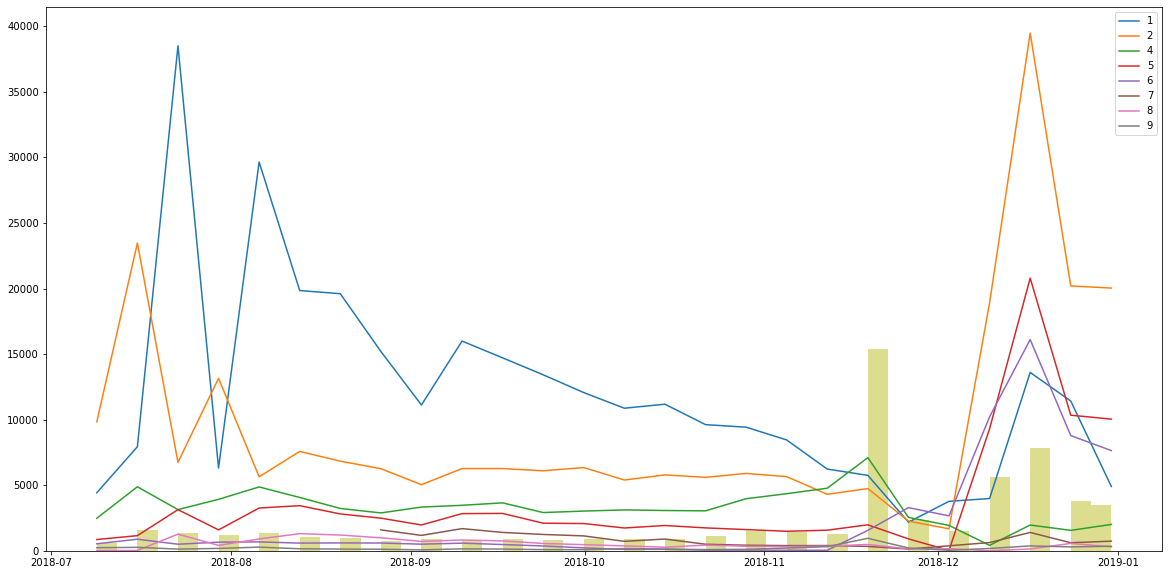

In [15]:
plt.figure(figsize=(20,10))
plt.plot(train_df.loc[(train_df['vas_id']==1.0, 'date') ].value_counts().sort_index(),label='1')
plt.plot(train_df.loc[(train_df['vas_id']==2.0, 'date') ].value_counts().sort_index(),label='2')
plt.plot(train_df.loc[(train_df['vas_id']==4.0, 'date') ].value_counts().sort_index(),label='4')
plt.plot(train_df.loc[(train_df['vas_id']==5.0, 'date') ].value_counts().sort_index(),label='5')
plt.plot(train_df.loc[(train_df['vas_id']==6.0, 'date') ].value_counts().sort_index(),label='6')
plt.plot(train_df.loc[(train_df['vas_id']==7.0, 'date') ].value_counts().sort_index(),label='7')
plt.plot(train_df.loc[(train_df['vas_id']==8.0, 'date') ].value_counts().sort_index(),label='8')
plt.plot(train_df.loc[(train_df['vas_id']==9.0, 'date') ].value_counts().sort_index(),label='9')
plt.hist(train_df.loc[(train_df['target']==1, 'date') ], bins=50, rwidth=5, stacked=False, alpha=0.5)
plt.legend()
plt.show()

Видно, что к-во предлагаемых услуг 1 и 2 уменьшалось вплоть до декабря, затем последовал большой скачек у всех услуг. Видимо, перед новым годом компания предложила какие-то выгодные условия по тарифам.

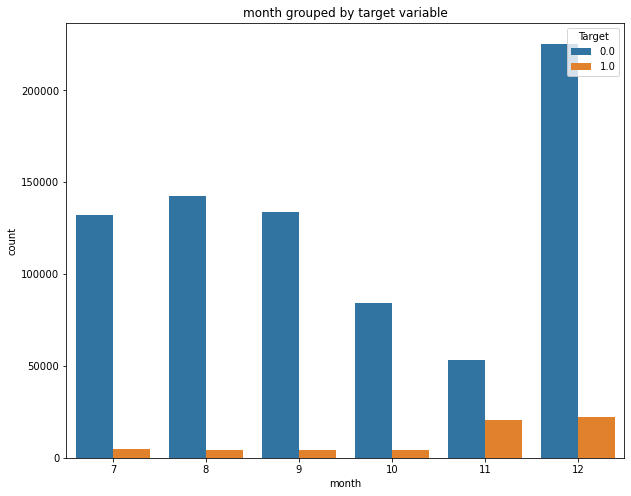

In [16]:
plt.figure(figsize=(10, 8))

sns.countplot(x="month", hue='target', data=train_df)
plt.title('month grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

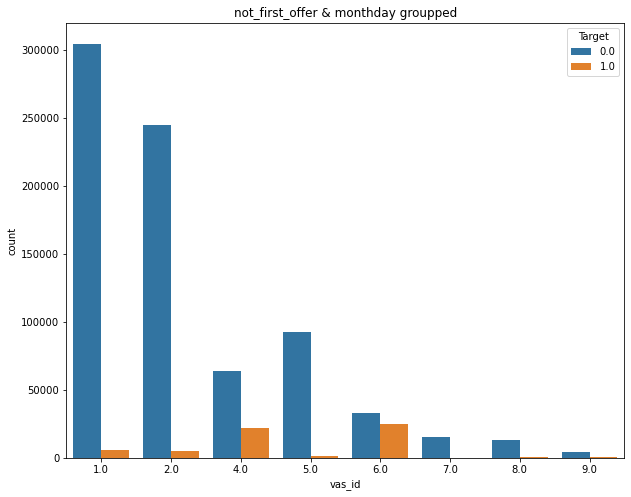

In [17]:
plt.figure(figsize=(10, 8))

sns.countplot(x="vas_id", hue='target', data=train_df)
plt.title('not_first_offer & monthday groupped')
plt.legend(title='Target', loc='upper right')

plt.show()

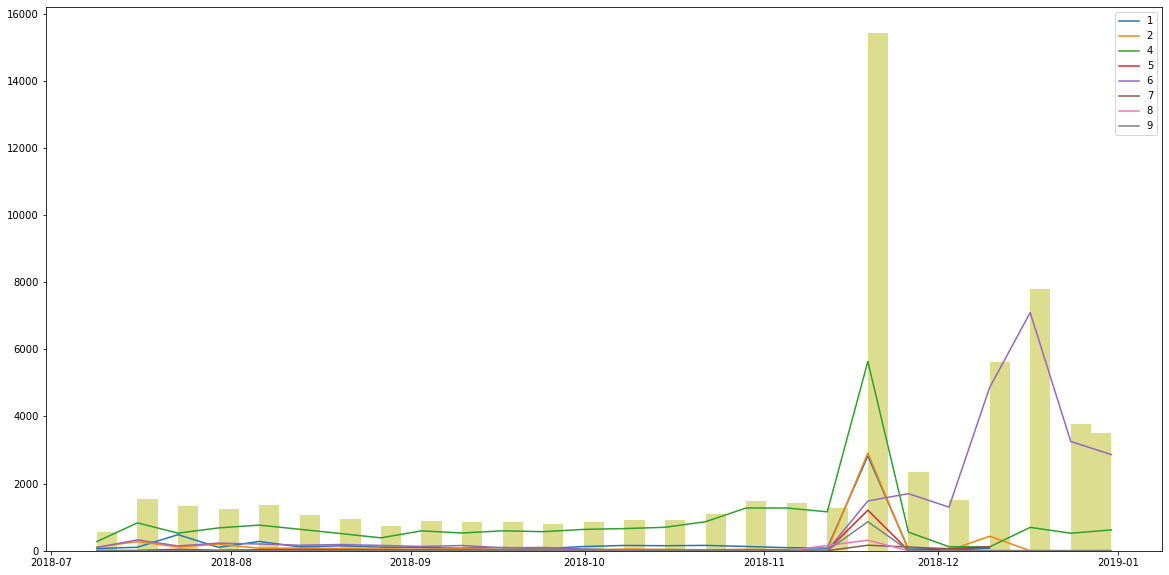

In [18]:
plt.figure(figsize=(20,10))
plt.plot(train_df.loc[((train_df['vas_id']==1.0) & (train_df['target']==1), 'date') ].value_counts().sort_index(),label='1')
plt.plot(train_df.loc[((train_df['vas_id']==2.0) & (train_df['target']==1), 'date') ].value_counts().sort_index(),label='2')
plt.plot(train_df.loc[((train_df['vas_id']==4.0) & (train_df['target']==1), 'date') ].value_counts().sort_index(),label='4')
plt.plot(train_df.loc[((train_df['vas_id']==5.0) & (train_df['target']==1), 'date') ].value_counts().sort_index(),label='5')
plt.plot(train_df.loc[((train_df['vas_id']==6.0) & (train_df['target']==1), 'date') ].value_counts().sort_index(),label='6')
plt.plot(train_df.loc[((train_df['vas_id']==7.0) & (train_df['target']==1), 'date') ].value_counts().sort_index(),label='7')
plt.plot(train_df.loc[((train_df['vas_id']==8.0) & (train_df['target']==1), 'date') ].value_counts().sort_index(),label='8')
plt.plot(train_df.loc[((train_df['vas_id']==9.0) & (train_df['target']==1), 'date') ].value_counts().sort_index(),label='9')
plt.hist(train_df.loc[(train_df['target']==1, 'date') ], bins=50, rwidth=5, stacked=False, alpha=0.5)
plt.legend()
plt.show()

По к-ву подключений лидируют услуги 4 и 6. 

In [19]:
train_df = train_df.sort_values('date')

In [20]:
train_df['not_first_offer'] = train_df.duplicated('id').astype(int)

Выделим пользователей, которым делали предложения больше 1 раза.

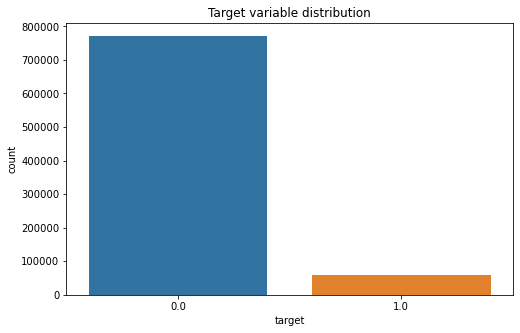

In [21]:
plt.figure(figsize=(8, 5))

sns.countplot(x='target', data=train_df)

plt.title('Target variable distribution')
plt.show()

Таргет имеет дисбаланс

Видим, что на услугу "6" положительный отклик, относительно отрицательного, на много выше остальных. Также "4" услуга имеет больший спрос.

Наблюдается сильный прекос отклика в положительную сторону в середине месяца.В целом видно, что в это время пик предложений, видимо маркетинг тоже пришел к выводу, что лучше звонить в эти дни.

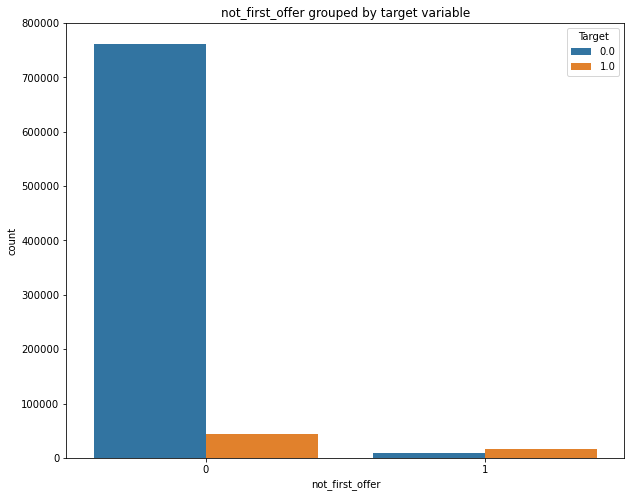

In [22]:
plt.figure(figsize=(10, 8))

sns.countplot(x="not_first_offer", hue='target', data=train_df)
plt.title('not_first_offer grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()


Кому звонили не в первый раз, имеют явный перекос в сторону положительного отклика.

In [23]:
sample = train_df.loc[(train_df['not_first_offer'] == 1) & (train_df['monthday'].isin([16, 17, 18, 19, 20]))]

In [24]:
sample['target'].value_counts(normalize=True)

1.0    0.830852
0.0    0.169148
Name: target, dtype: float64

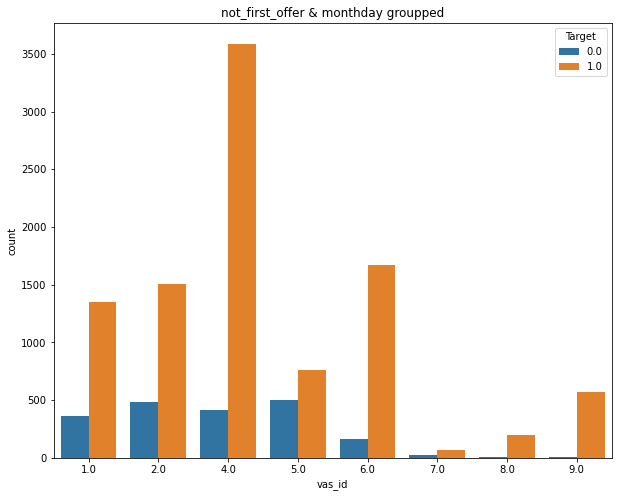

In [25]:
plt.figure(figsize=(10, 8))

sns.countplot(x="vas_id", hue='target', data=sample)
plt.title('not_first_offer & monthday groupped')
plt.legend(title='Target', loc='upper right')

plt.show()

Из приведенных выше данных, можно сделать предположение: "Всегда нужно звонить повторно, звонить стоит в середине месяца". При этом не чаще раза в месяц, и предлагать разные услуги. Даже без дополнительных описательных характеристик пользователя, мы видим, что вероятность положительного отклика на любую услугу в этих рамках много выше.

In [26]:
dic = {'vas_id':[],
       '0':[],
       '1':[]
        }
vas_ids = np.sort(train_df['vas_id'].unique())

for vas_id in vas_ids:
    temp_df = train_df.loc[(train_df['vas_id']==vas_id)]
    c_0 = len(temp_df.loc[(temp_df['target']==0)])/len(temp_df['target'])
    c_1 = len(temp_df.loc[(temp_df['target']==1)])/len(temp_df['target'])
    dic['vas_id'].append(vas_id)
    dic['0'].append(f'{c_0:.3f}')
    dic['1'].append(f'{c_1:.3f}')
pd.DataFrame(dic)

,vas_id,0,1
0,1.0,0.982,0.018
1,2.0,0.981,0.019
2,4.0,0.746,0.254
3,5.0,0.982,0.018
4,6.0,0.573,0.427
5,7.0,0.986,0.014
6,8.0,0.974,0.026
7,9.0,0.817,0.183


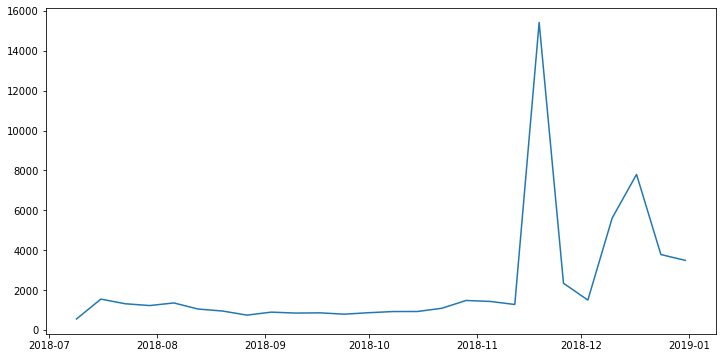

In [27]:
plt.figure(figsize=(12,6))
plt.plot(train_df.loc[(train_df['target']==1, 'date') ].value_counts().sort_index())

In [28]:
train_df.head()

,id,vas_id,buy_time,target,date,monthday,month,not_first_offer
578818,2582523,2.0,1531083600,0.0,2018-07-08 21:00:00,8,7,0
603994,1292549,2.0,1531083600,0.0,2018-07-08 21:00:00,8,7,0
293389,4053116,1.0,1531083600,0.0,2018-07-08 21:00:00,8,7,0
293387,4158361,2.0,1531083600,0.0,2018-07-08 21:00:00,8,7,0
254350,3754468,4.0,1531083600,0.0,2018-07-08 21:00:00,8,7,0


In [31]:
features_df = dd.read_csv(FEATURES_DATA, sep='\t')

In [32]:
features_df.head()

,Unnamed: 0,id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
0,0,2013026,1531688400,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-301.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,1,2014722,1539550800,36.690029,152.400888,448.069214,563.833202,463.841754,568.99821,-16.08618,...,-891.373846,-544.770792,-20.996269,48.369552,80.252276,-13.832889,-0.694428,-1.175933,-0.45614,0.0
2,2,2015199,1545598800,-67.019971,157.050888,-63.180786,178.103202,-68.598246,156.99821,3.51382,...,-977.373846,-613.770792,-12.996269,-37.630448,10829.252276,-25.832889,-0.694428,-12.175933,-0.45614,0.0
3,3,2021765,1534107600,7.010029,150.200888,-6.930786,216.213202,76.621754,351.84821,-16.08618,...,-973.373846,-613.770792,-23.996269,-37.630448,-205.747724,-24.832889,-0.694428,-11.175933,-0.45614,1.0
4,4,2027465,1533502800,-90.439971,134.220888,-104.380786,153.643202,-109.798246,132.53821,-16.08618,...,1643.626154,2007.229208,206.003731,-21.630448,6667.252276,92.167111,-0.694428,49.824067,47.54386,0.0


In [33]:
features_df = features_df.drop('Unnamed: 0', axis=1)

In [34]:
train_df.drop(['month', 'monthday'], axis=1, inplace=True)

In [35]:
train_df

,id,vas_id,buy_time,target,date,not_first_offer
578818,2582523,2.0,1531083600,0.0,2018-07-08 21:00:00,0
603994,1292549,2.0,1531083600,0.0,2018-07-08 21:00:00,0
293389,4053116,1.0,1531083600,0.0,2018-07-08 21:00:00,0
293387,4158361,2.0,1531083600,0.0,2018-07-08 21:00:00,0
254350,3754468,4.0,1531083600,0.0,2018-07-08 21:00:00,0
...,...,...,...,...,...,...
535199,555080,5.0,1546203600,0.0,2018-12-30 21:00:00,0
535198,1729471,5.0,1546203600,0.0,2018-12-30 21:00:00,0
535136,3676177,2.0,1546203600,0.0,2018-12-30 21:00:00,0
535090,2255038,2.0,1546203600,0.0,2018-12-30 21:00:00,0


Объединим train_df с features_df. 

Чтобы смерджить описательные фичи, возьмем из них только те id, которые есть в трейн датасете.

In [36]:
train_list_index = list(train_df['id'].unique())


In [37]:
features_df = features_df.loc[features_df['id'].isin(train_list_index)].compute()

In [39]:
features_df = features_df.sort_values(by="buy_time")

In [40]:
data_train = pd.merge_asof(train_df, features_df, on='buy_time', by='id', direction='nearest')

In [41]:
data_train

,id,vas_id,buy_time,target,date,not_first_offer,0,1,2,3,...,243,244,245,246,247,248,249,250,251,252
0,2582523,2.0,1531083600,0.0,2018-07-08 21:00:00,0,314.560029,9.290888,342.989214,7.523202,...,6488.626154,-574.770792,-24.996269,121.369552,142.252276,-16.832889,-0.694428,-11.175933,-0.45614,0.0
1,1292549,2.0,1531083600,0.0,2018-07-08 21:00:00,0,93.880029,-217.499112,79.939214,-270.106798,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
2,4053116,1.0,1531083600,0.0,2018-07-08 21:00:00,0,125.110029,152.190888,111.169214,107.213202,...,-956.373846,-613.770792,-18.996269,761.369552,-213.747724,26.167111,-0.694428,39.824067,-0.45614,1.0
3,4158361,2.0,1531083600,0.0,2018-07-08 21:00:00,0,-7.829971,-266.839112,-20.500786,-304.196798,...,1257.626154,495.229208,-19.996269,-37.630448,-108.747724,-25.832889,-0.694428,-12.175933,-0.45614,1.0
4,3754468,4.0,1531083600,0.0,2018-07-08 21:00:00,0,83.620029,535.610888,72.219214,503.343202,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831648,555080,5.0,1546203600,0.0,2018-12-30 21:00:00,0,-96.799971,-408.179112,-110.740786,-460.786798,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
831649,1729471,5.0,1546203600,0.0,2018-12-30 21:00:00,0,-86.209971,-397.589112,-100.150786,-450.196798,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
831650,3676177,2.0,1546203600,0.0,2018-12-30 21:00:00,0,-96.799971,-408.179112,-110.740786,-460.786798,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
831651,2255038,2.0,1546203600,0.0,2018-12-30 21:00:00,0,-96.799971,49.450888,-104.390786,219.293202,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0


Добавим новых фичей, разабьем время на дни, недели, месяцы

In [42]:
data_train['week_on_month'] = data_train['date'].apply(lambda x: pd.to_datetime(x).day//7)
data_train['day'] = data_train['date'].apply(lambda x: pd.to_datetime(x).day)
data_train['month'] = data_train['date'].apply(lambda x: pd.to_datetime(x).month)
data_train = data_train.drop('date', axis=1)
data_train = data_train.drop('buy_time', axis=1)

In [43]:
data_train

,id,vas_id,target,not_first_offer,0,1,2,3,4,5,...,246,247,248,249,250,251,252,week_on_month,day,month
0,2582523,2.0,0.0,0,314.560029,9.290888,342.989214,7.523202,337.571754,-13.58179,...,121.369552,142.252276,-16.832889,-0.694428,-11.175933,-0.45614,0.0,1,8,7
1,1292549,2.0,0.0,0,93.880029,-217.499112,79.939214,-270.106798,74.521754,-291.21179,...,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0,1,8,7
2,4053116,1.0,0.0,0,125.110029,152.190888,111.169214,107.213202,105.751754,86.10821,...,761.369552,-213.747724,26.167111,-0.694428,39.824067,-0.45614,1.0,1,8,7
3,4158361,2.0,0.0,0,-7.829971,-266.839112,-20.500786,-304.196798,-25.918246,-325.30179,...,-37.630448,-108.747724,-25.832889,-0.694428,-12.175933,-0.45614,1.0,1,8,7
4,3754468,4.0,0.0,0,83.620029,535.610888,72.219214,503.343202,66.801754,502.66821,...,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0,1,8,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831648,555080,5.0,0.0,0,-96.799971,-408.179112,-110.740786,-460.786798,-116.158246,-481.89179,...,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0,4,30,12
831649,1729471,5.0,0.0,0,-86.209971,-397.589112,-100.150786,-450.196798,-105.568246,-471.30179,...,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0,4,30,12
831650,3676177,2.0,0.0,0,-96.799971,-408.179112,-110.740786,-460.786798,-116.158246,-481.89179,...,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0,4,30,12
831651,2255038,2.0,0.0,0,-96.799971,49.450888,-104.390786,219.293202,-109.808246,200.30821,...,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0,4,30,12


In [44]:
print("Есть ли дубли в строках?", data_train.duplicated().sum())

Есть ли дубли в строках? 0


In [29]:
train_data.drop_duplicates(inplace=True)

In [45]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 831653 entries, 0 to 831652
Columns: 260 entries, id to month
dtypes: float64(255), int32(1), int64(4)
memory usage: 1.6 GB


In [46]:
data_prelim = data_train.copy()

X_train = data_prelim.drop('target', axis=1)
y_train = data_prelim['target']

In [47]:
X_train.head()

,id,vas_id,not_first_offer,0,1,2,3,4,5,6,...,246,247,248,249,250,251,252,week_on_month,day,month
0,2582523,2.0,0,314.560029,9.290888,342.989214,7.523202,337.571754,-13.58179,-16.08618,...,121.369552,142.252276,-16.832889,-0.694428,-11.175933,-0.45614,0.0,1,8,7
1,1292549,2.0,0,93.880029,-217.499112,79.939214,-270.106798,74.521754,-291.21179,-16.08618,...,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0,1,8,7
2,4053116,1.0,0,125.110029,152.190888,111.169214,107.213202,105.751754,86.10821,-16.08618,...,761.369552,-213.747724,26.167111,-0.694428,39.824067,-0.45614,1.0,1,8,7
3,4158361,2.0,0,-7.829971,-266.839112,-20.500786,-304.196798,-25.918246,-325.30179,-16.08618,...,-37.630448,-108.747724,-25.832889,-0.694428,-12.175933,-0.45614,1.0,1,8,7
4,3754468,4.0,0,83.620029,535.610888,72.219214,503.343202,66.801754,502.66821,-16.08618,...,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0,1,8,7


In [48]:
X_nunique = X_train.apply(lambda x: x.nunique(dropna=False))

In [49]:
X_nunique

id                 806613
vas_id                  8
not_first_offer         2
0                   46159
1                  112909
                    ...  
251                   248
252                    30
week_on_month           5
day                    21
month                   6
Length: 259, dtype: int64

In [50]:
f_all = set(X_nunique.index.tolist())
len(f_all)

259

In [51]:
# Константные признаки
f_const = set(X_nunique[X_nunique == 1].index.tolist())

f_other = f_all - f_const
len(f_const), len(f_other)

(5, 254)

In [54]:
# Бинарные
f_binary = set(X_train.loc[:, f_other].columns[(
                      (X_train.loc[:, f_other].max() == 1) & \
                      (X_train.loc[:, f_other].min() == 0) & \
                      (X_train.loc[:, f_other].isnull().sum() == 0))])


f_other = f_other - f_binary

len(f_binary), len(f_other)

(1, 253)

In [55]:
# Категориальные
f_categorical = set(X_nunique.loc[f_other][X_nunique.loc[f_other] <= 5].index.tolist())
f_numeric_extra = f_categorical
f_other = f_other - f_categorical

len(f_categorical), len(f_other)

(24, 229)

In [57]:
# Вещественные признаки
f_numeric = (X_train[f_other].fillna(0).astype(int).sum() - X_train[f_other].fillna(0).sum()).abs() 
f_numeric = set(f_numeric[f_numeric > 0].index.tolist())
f_other = f_other - f_numeric
# f_other = f_all - (f_numeric | f_const)
len(f_numeric), len(f_other)

(224, 5)

In [58]:
f_numeric = f_numeric | f_other
f_other = f_other - f_numeric
len(f_other)

0

In [59]:
print('f_all:', len(f_all))
print()
print('f_const:', len(f_const))
print('f_binary:', len(f_binary))
print('f_categorical:', len(f_categorical))
print('f_numeric:', len(f_numeric))

f_ok = list(f_binary | f_categorical | f_numeric)
f_binary, f_categorical, f_numeric = list(f_binary), list(f_categorical), list(f_numeric)

f_all: 259

f_const: 5
f_binary: 1
f_categorical: 24
f_numeric: 229


разабьем даные на тренировочные и тестовые

In [63]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train, y_train, test_size=0.20, random_state=42, shuffle=False)

In [65]:
y_train.value_counts()/y_train.shape

0.0    0.927631
1.0    0.072369
Name: target, dtype: float64

Сбаленсируем Target

In [77]:
from imblearn.under_sampling import RandomUnderSampler

In [78]:
ros = RandomUnderSampler(random_state=42)
X_train, Y_train = ros.fit_resample(X_train, Y_train)

print("Train")
print(Y_train.value_counts()/y_train.shape[0])

Train
0.0    0.056824
1.0    0.056824
Name: target, dtype: float64


In [79]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("DataFrame не содердит следующие колонки: %s" % cols_error)

In [80]:
f_prep_pipeline = make_pipeline(
    ColumnSelector(columns=f_ok),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            ColumnSelector(f_numeric),
            SimpleImputer(strategy="median"), # Заполнение пропусков.
            StandardScaler()
        )),
        ("categorical_features", make_pipeline(
            ColumnSelector(f_categorical),
            SimpleImputer(strategy="most_frequent"),
            OneHotEncoder(handle_unknown='ignore')
        )),
        ("boolean_features", make_pipeline(
            ColumnSelector(f_binary),
        ))
    ])
)

In [89]:
rf_pipe = make_pipeline(
    f_prep_pipeline,
    RandomForestClassifier(random_state=42)
)

In [91]:
rf_pipe.fit(X_train, Y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columnselector',
                                  ColumnSelector(columns=['220', '99', '175',
                                                          '158', '125', '63',
                                                          '205', '224', '136',
                                                          '173',
                                                          'week_on_month', '29',
                                                          '53', '169', '83',
                                                          '51', '112', '202',
                                                          '235', '143', '185',
                                                          '248', '216', '93',
                                                          '24', '55', '87',
                                                          '126', 'day', '217', ...])),
                                 ('featureunion',
             

In [92]:
preds = rf_pipe.predict(X_test)

In [93]:
f1_score(Y_test, preds, average='macro')

0.5542299868693763

In [94]:
print(classification_report(Y_test, preds))

              precision    recall  f1-score   support

         0.0       1.00      0.65      0.79    153403
         1.0       0.19      1.00      0.32     12928

    accuracy                           0.67    166331
   macro avg       0.60      0.82      0.55    166331
weighted avg       0.94      0.67      0.75    166331



In [99]:
print(classification_report(Y_test, preds_test))

              precision    recall  f1-score   support

         0.0       1.00      0.43      0.60    153403
         1.0       0.13      1.00      0.23     12928

    accuracy                           0.48    166331
   macro avg       0.56      0.72      0.42    166331
weighted avg       0.93      0.48      0.57    166331



In [101]:
import catboost as catb

In [118]:
catb_model = catb.CatBoostClassifier(random_state=21,
                                    score_function='L2',
                                    depth = 7,
                                    eval_metric='AUC',
                                    l2_leaf_reg = 4,
                                    learning_rate=0.01,
                                    custom_metric=['Precision', 'Recall'],
                                    iterations=1000,                                    
                                )

In [119]:
cat_boost_pipe = make_pipeline(
    f_prep_pipeline,
    catb_model
)

In [120]:
cat_boost_pipe.fit(X_train, Y_train)

0:	total: 74ms	remaining: 1m 13s
1:	total: 141ms	remaining: 1m 10s
2:	total: 217ms	remaining: 1m 12s
3:	total: 284ms	remaining: 1m 10s
4:	total: 362ms	remaining: 1m 12s
5:	total: 432ms	remaining: 1m 11s
6:	total: 505ms	remaining: 1m 11s
7:	total: 578ms	remaining: 1m 11s
8:	total: 646ms	remaining: 1m 11s
9:	total: 713ms	remaining: 1m 10s
10:	total: 780ms	remaining: 1m 10s
11:	total: 853ms	remaining: 1m 10s
12:	total: 927ms	remaining: 1m 10s
13:	total: 1s	remaining: 1m 10s
14:	total: 1.08s	remaining: 1m 10s
15:	total: 1.15s	remaining: 1m 10s
16:	total: 1.22s	remaining: 1m 10s
17:	total: 1.28s	remaining: 1m 10s
18:	total: 1.36s	remaining: 1m 10s
19:	total: 1.42s	remaining: 1m 9s
20:	total: 1.49s	remaining: 1m 9s
21:	total: 1.56s	remaining: 1m 9s
22:	total: 1.63s	remaining: 1m 9s
23:	total: 1.7s	remaining: 1m 9s
24:	total: 1.77s	remaining: 1m 8s
25:	total: 1.84s	remaining: 1m 8s
26:	total: 1.9s	remaining: 1m 8s
27:	total: 1.97s	remaining: 1m 8s
28:	total: 2.04s	remaining: 1m 8s
29:	total: 

242:	total: 17.6s	remaining: 55s
243:	total: 17.7s	remaining: 54.9s
244:	total: 17.8s	remaining: 54.8s
245:	total: 17.8s	remaining: 54.7s
246:	total: 17.9s	remaining: 54.6s
247:	total: 18s	remaining: 54.5s
248:	total: 18s	remaining: 54.4s
249:	total: 18.1s	remaining: 54.3s
250:	total: 18.2s	remaining: 54.3s
251:	total: 18.2s	remaining: 54.2s
252:	total: 18.3s	remaining: 54.1s
253:	total: 18.4s	remaining: 54s
254:	total: 18.4s	remaining: 53.9s
255:	total: 18.5s	remaining: 53.8s
256:	total: 18.6s	remaining: 53.7s
257:	total: 18.6s	remaining: 53.6s
258:	total: 18.7s	remaining: 53.5s
259:	total: 18.8s	remaining: 53.4s
260:	total: 18.8s	remaining: 53.3s
261:	total: 18.9s	remaining: 53.2s
262:	total: 19s	remaining: 53.2s
263:	total: 19s	remaining: 53.1s
264:	total: 19.1s	remaining: 52.9s
265:	total: 19.2s	remaining: 52.9s
266:	total: 19.2s	remaining: 52.8s
267:	total: 19.3s	remaining: 52.7s
268:	total: 19.4s	remaining: 52.6s
269:	total: 19.4s	remaining: 52.5s
270:	total: 19.5s	remaining: 52.

482:	total: 33.1s	remaining: 35.4s
483:	total: 33.1s	remaining: 35.3s
484:	total: 33.2s	remaining: 35.2s
485:	total: 33.3s	remaining: 35.2s
486:	total: 33.3s	remaining: 35.1s
487:	total: 33.4s	remaining: 35s
488:	total: 33.4s	remaining: 35s
489:	total: 33.5s	remaining: 34.9s
490:	total: 33.6s	remaining: 34.8s
491:	total: 33.6s	remaining: 34.7s
492:	total: 33.7s	remaining: 34.6s
493:	total: 33.7s	remaining: 34.6s
494:	total: 33.8s	remaining: 34.5s
495:	total: 33.8s	remaining: 34.4s
496:	total: 33.9s	remaining: 34.3s
497:	total: 34s	remaining: 34.2s
498:	total: 34s	remaining: 34.2s
499:	total: 34.1s	remaining: 34.1s
500:	total: 34.2s	remaining: 34s
501:	total: 34.2s	remaining: 33.9s
502:	total: 34.3s	remaining: 33.9s
503:	total: 34.3s	remaining: 33.8s
504:	total: 34.4s	remaining: 33.7s
505:	total: 34.5s	remaining: 33.6s
506:	total: 34.5s	remaining: 33.6s
507:	total: 34.6s	remaining: 33.5s
508:	total: 34.6s	remaining: 33.4s
509:	total: 34.7s	remaining: 33.3s
510:	total: 34.7s	remaining: 3

720:	total: 47.6s	remaining: 18.4s
721:	total: 47.7s	remaining: 18.4s
722:	total: 47.8s	remaining: 18.3s
723:	total: 47.8s	remaining: 18.2s
724:	total: 47.9s	remaining: 18.2s
725:	total: 47.9s	remaining: 18.1s
726:	total: 48s	remaining: 18s
727:	total: 48.1s	remaining: 18s
728:	total: 48.1s	remaining: 17.9s
729:	total: 48.2s	remaining: 17.8s
730:	total: 48.3s	remaining: 17.8s
731:	total: 48.3s	remaining: 17.7s
732:	total: 48.4s	remaining: 17.6s
733:	total: 48.5s	remaining: 17.6s
734:	total: 48.5s	remaining: 17.5s
735:	total: 48.6s	remaining: 17.4s
736:	total: 48.7s	remaining: 17.4s
737:	total: 48.7s	remaining: 17.3s
738:	total: 48.8s	remaining: 17.2s
739:	total: 48.8s	remaining: 17.2s
740:	total: 48.9s	remaining: 17.1s
741:	total: 49s	remaining: 17s
742:	total: 49s	remaining: 17s
743:	total: 49.1s	remaining: 16.9s
744:	total: 49.1s	remaining: 16.8s
745:	total: 49.2s	remaining: 16.8s
746:	total: 49.3s	remaining: 16.7s
747:	total: 49.3s	remaining: 16.6s
748:	total: 49.4s	remaining: 16.6s

958:	total: 1m 2s	remaining: 2.66s
959:	total: 1m 2s	remaining: 2.59s
960:	total: 1m 2s	remaining: 2.53s
961:	total: 1m 2s	remaining: 2.46s
962:	total: 1m 2s	remaining: 2.4s
963:	total: 1m 2s	remaining: 2.33s
964:	total: 1m 2s	remaining: 2.27s
965:	total: 1m 2s	remaining: 2.2s
966:	total: 1m 2s	remaining: 2.14s
967:	total: 1m 2s	remaining: 2.07s
968:	total: 1m 2s	remaining: 2.01s
969:	total: 1m 2s	remaining: 1.94s
970:	total: 1m 2s	remaining: 1.88s
971:	total: 1m 2s	remaining: 1.81s
972:	total: 1m 3s	remaining: 1.75s
973:	total: 1m 3s	remaining: 1.68s
974:	total: 1m 3s	remaining: 1.62s
975:	total: 1m 3s	remaining: 1.55s
976:	total: 1m 3s	remaining: 1.49s
977:	total: 1m 3s	remaining: 1.42s
978:	total: 1m 3s	remaining: 1.36s
979:	total: 1m 3s	remaining: 1.29s
980:	total: 1m 3s	remaining: 1.23s
981:	total: 1m 3s	remaining: 1.17s
982:	total: 1m 3s	remaining: 1.1s
983:	total: 1m 3s	remaining: 1.03s
984:	total: 1m 3s	remaining: 971ms
985:	total: 1m 3s	remaining: 906ms
986:	total: 1m 3s	remai

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columnselector',
                                  ColumnSelector(columns=['220', '99', '175',
                                                          '158', '125', '63',
                                                          '205', '224', '136',
                                                          '173',
                                                          'week_on_month', '29',
                                                          '53', '169', '83',
                                                          '51', '112', '202',
                                                          '235', '143', '185',
                                                          '248', '216', '93',
                                                          '24', '55', '87',
                                                          '126', 'day', '217', ...])),
                                 ('featureunion',
             

In [121]:
preds_train = cat_boost_pipe.predict(X_train)
f1_score(Y_train, preds_train, average='macro')

0.8860692698502132

In [122]:
preds_test = cat_boost_pipe.predict(X_test)
f1_score(Y_test, preds_test, average='macro')

0.73122419326917

In [123]:
print(classification_report(Y_test, preds_test))

              precision    recall  f1-score   support

         0.0       1.00      0.86      0.92    153403
         1.0       0.37      1.00      0.54     12928

    accuracy                           0.87    166331
   macro avg       0.68      0.93      0.73    166331
weighted avg       0.95      0.87      0.89    166331



Попробовав несколько разных моделей принял решение взять модель CatBoostClassifier. По метрикам показывает хорошее качество и скорость.
F1_macro: 0.73